In [53]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import LeakyReLU, PReLU, Dropout
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from keras import regularizers

# load data

In [54]:
cab_df = pd.read_csv("cab_rides.csv",delimiter='\t',encoding = "utf-16")
weather_df = pd.read_csv("weather.csv",delimiter='\t',encoding = "utf-16")

# preprocess data

In [60]:
cab_df['date_time'] = pd.to_datetime(cab_df['time_stamp']/1000, unit='s')
weather_df['date_time'] = pd.to_datetime(weather_df['time_stamp'], unit='s')
cab_df['merge_date'] = cab_df.source.astype(str) +" - "+ cab_df.date_time.dt.date.astype("str") +" - "+ cab_df.date_time.dt.hour.astype("str")
weather_df['merge_date'] = weather_df.location.astype(str) +" - "+ weather_df.date_time.dt.date.astype("str") +" - "+ weather_df.date_time.dt.hour.astype("str")
weather_df.index = weather_df['merge_date']
merged_df = cab_df.join(weather_df,on=['merge_date'],rsuffix ='_w')
merged_df['rain'].fillna(0,inplace=True)
merged_df = merged_df[pd.notnull(merged_df['date_time_w'])]
merged_df = merged_df[pd.notnull(merged_df['price'])]
merged_df['day'] = merged_df.date_time.dt.dayofweek
merged_df['hour'] = merged_df.date_time.dt.hour
merged_df.columns
merged_df.count()
x = merged_df[merged_df.product_id=='lyft_line'][['day','distance','hour','temp','clouds', 'pressure','humidity', 'wind', 'rain']]
features = list(x.columns) 
y = merged_df[merged_df.product_id=='lyft_line']['price']
x.reset_index(inplace=True)
x = x.drop(columns=['index'])
sc = StandardScaler()
x = sc.fit_transform(x)
y = np.array(y)

# split data into training and testing sets

In [61]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.1, random_state = 0)

# Our model

In [62]:
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras import Sequential
model = Sequential()
model.add(Conv1D(256, kernel_size = 8,padding='same',activation='relu',strides=1, input_shape=(9,1)))
model.add(MaxPooling1D((2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(128, kernel_size = 4,padding='same',activation='relu',strides=1))
model.add(MaxPooling1D((2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(128, kernel_size = 4,padding='same',activation='relu',strides=1))
model.add(MaxPooling1D((2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(64, kernel_size = 2,padding='same',activation='relu',strides=1))
model.add(MaxPooling1D((2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size = 2,padding='same',activation='relu',strides=1))
model.add(MaxPooling1D((2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size = 2,padding='same',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1,activation='linear'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 9, 256)            2304      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 5, 256)            0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 5, 256)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 5, 128)            131200    
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 3, 128)            0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 3, 128)            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 3, 128)           

# Train

In [63]:
sgd = optimizers.SGD(lr=0.01, momentum=0.1, clipnorm=1.)
model.compile(optimizer = sgd,
              loss = 'mae',
              metrics=['mape'])
history = model.fit(train_x.reshape(len(train_x),9,1), train_y,
          batch_size=128,
          epochs=1000,
          validation_data = (test_x.reshape(len(test_x),9,1), test_y))

Train on 81936 samples, validate on 9105 samples
Epoch 1/1000
14464/81936 [====>.........................] - ETA: 8s - loss: 4.7073 - mape: 75.8272

KeyboardInterrupt: 

# model accuracy

In [64]:
pyplot.plot(np.full((len(history.history['val_mape']),), 100)-history.history['val_mape'])
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.show()

NameError: name 'history' is not defined

In [65]:
mape = history.history['val_mape'][-1]
accuracy_DNN = 100-mape
print('Accuracy:', round(accuracy_DNN, 2), '%.')

NameError: name 'history' is not defined

# Compare DNN with other models

In [66]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

LASSO

In [10]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(train_x, train_y)
predictions = lasso.predict(test_x)
errors = abs(predictions - test_y)
mape = 100 * (errors / test_y)
accuracy_LASSO = 100 - np.mean(mape)
print('Accuracy:', round(accuracy_LASSO, 2), '%.')

Accuracy: 79.69 %.


Linear Regression

In [11]:
lr = linear_model.LinearRegression()
lr.fit(train_x, train_y)
predictions = lr.predict(test_x)
errors = abs(predictions - test_y)
mape = 100 * (errors / test_y)
accuracy_LR = 100 - np.mean(mape)
print('Accuracy:', round(accuracy_LR, 2), '%.')

Accuracy: 80.18 %.


Random Forest

In [67]:
rf = RandomForestRegressor()
rf.fit(train_x, train_y)
predictions = rf.predict(test_x)
errors = abs(predictions - test_y)
mape = 100 * (errors / test_y)
accuracy_RF = 100 - np.mean(mape)
print('Accuracy:', round(accuracy_RF, 2), '%.')

C:\Users\kevin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 92.13 %.


In [70]:
import pandas as pd
feature_importances = pd.DataFrame(rf.feature_importances_,
                                    index = features,
                                    columns=['importance']).sort_values('importance', 
                                    ascending=False)

print(feature_importances)

          importance
distance    0.662663
pressure    0.094050
day         0.068718
hour        0.046352
temp        0.043973
wind        0.030708
clouds      0.021849
humidity    0.020142
rain        0.011545


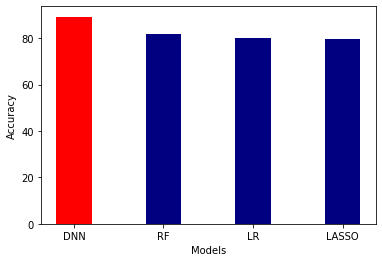

In [13]:
pyplot.bar(['DNN','RF','LR','LASSO'], [accuracy_DNN,accuracy_RF,accuracy_LR,accuracy_LASSO], width=0.4, color=['red','navy','navy','navy'])
pyplot.xlabel('Models')
pyplot.ylabel('Accuracy')
pyplot.show()

# Model Plot

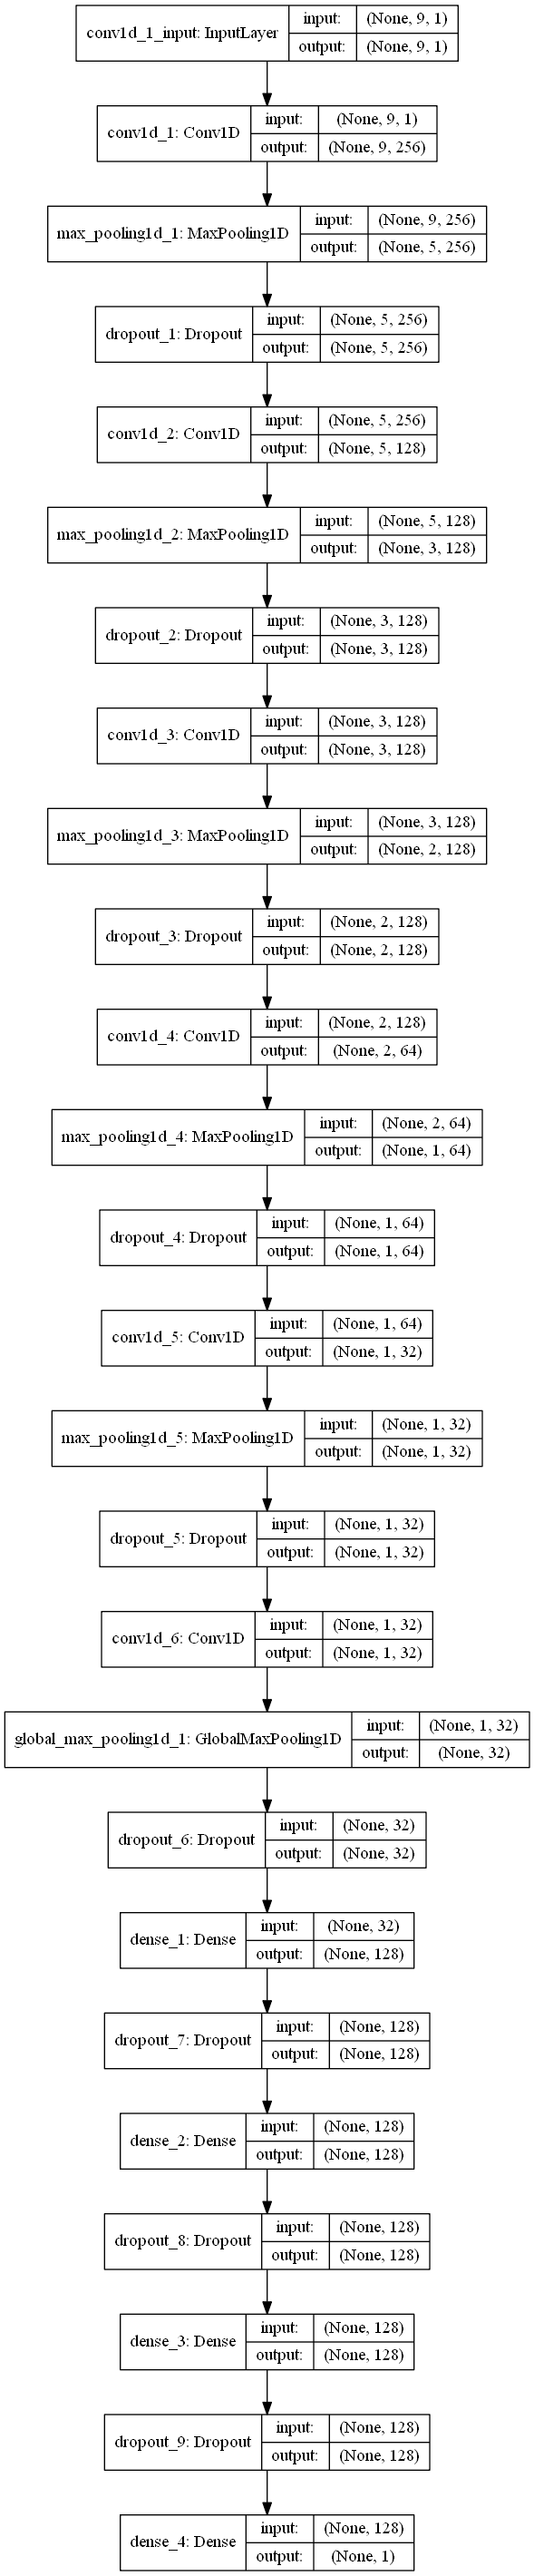

In [7]:
from keras.utils import plot_model

plot_model(
    model,
    to_file='dnn.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)